In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)
local_bw_rmses = {}
global_bw_rmses = {}

2


0.017023708593966423 0.001623790077022954 inf


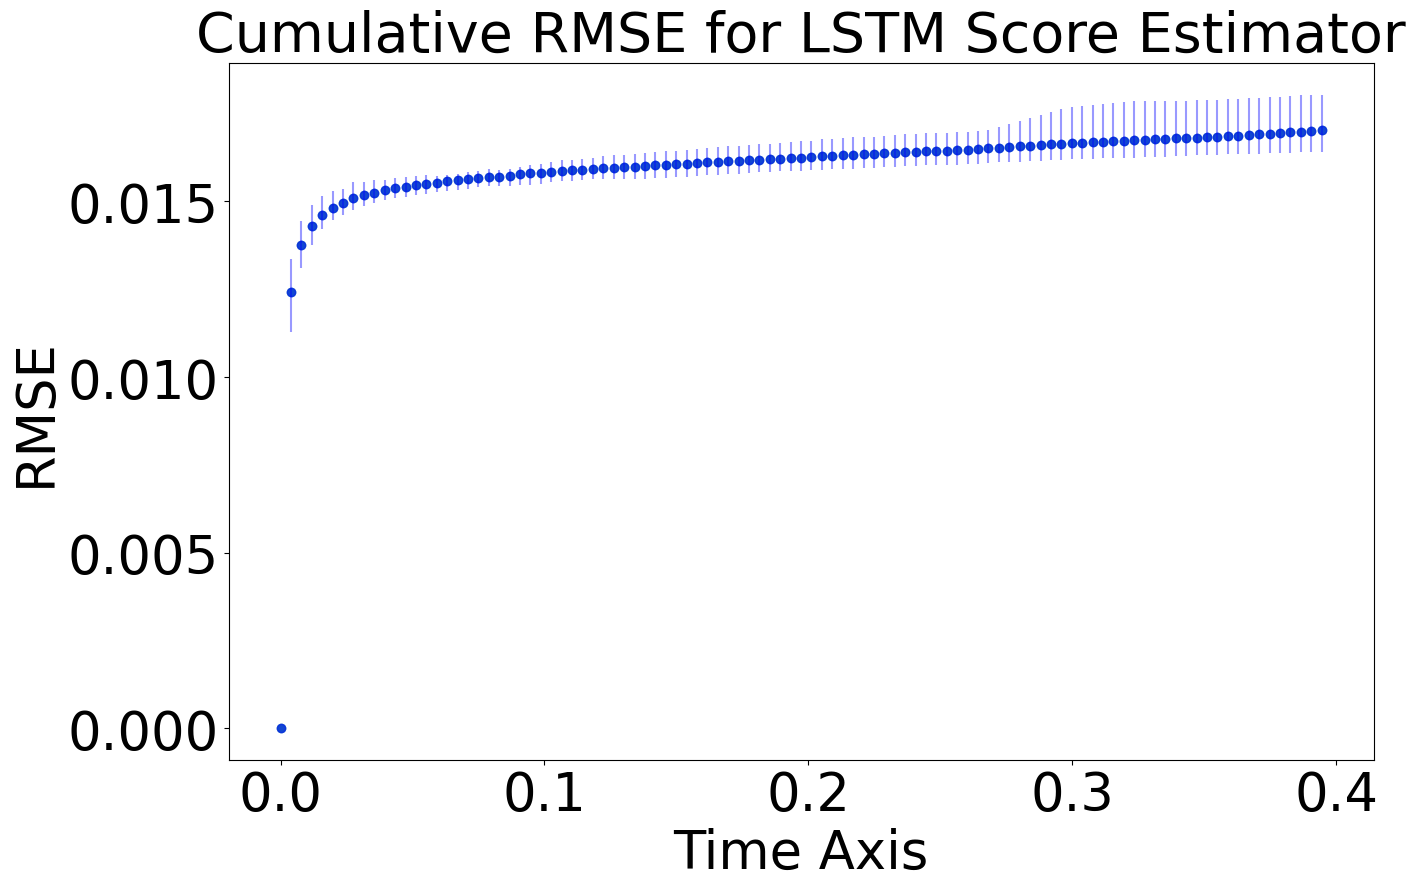

Final time cumulative RMSE local-time error 0.017023708593966423 with final IQR (0.01641941890541941, 0.018043208982442365) at Nepoch 60

0.015118554551794635 0.00037132155888160677 0.017023708593966423


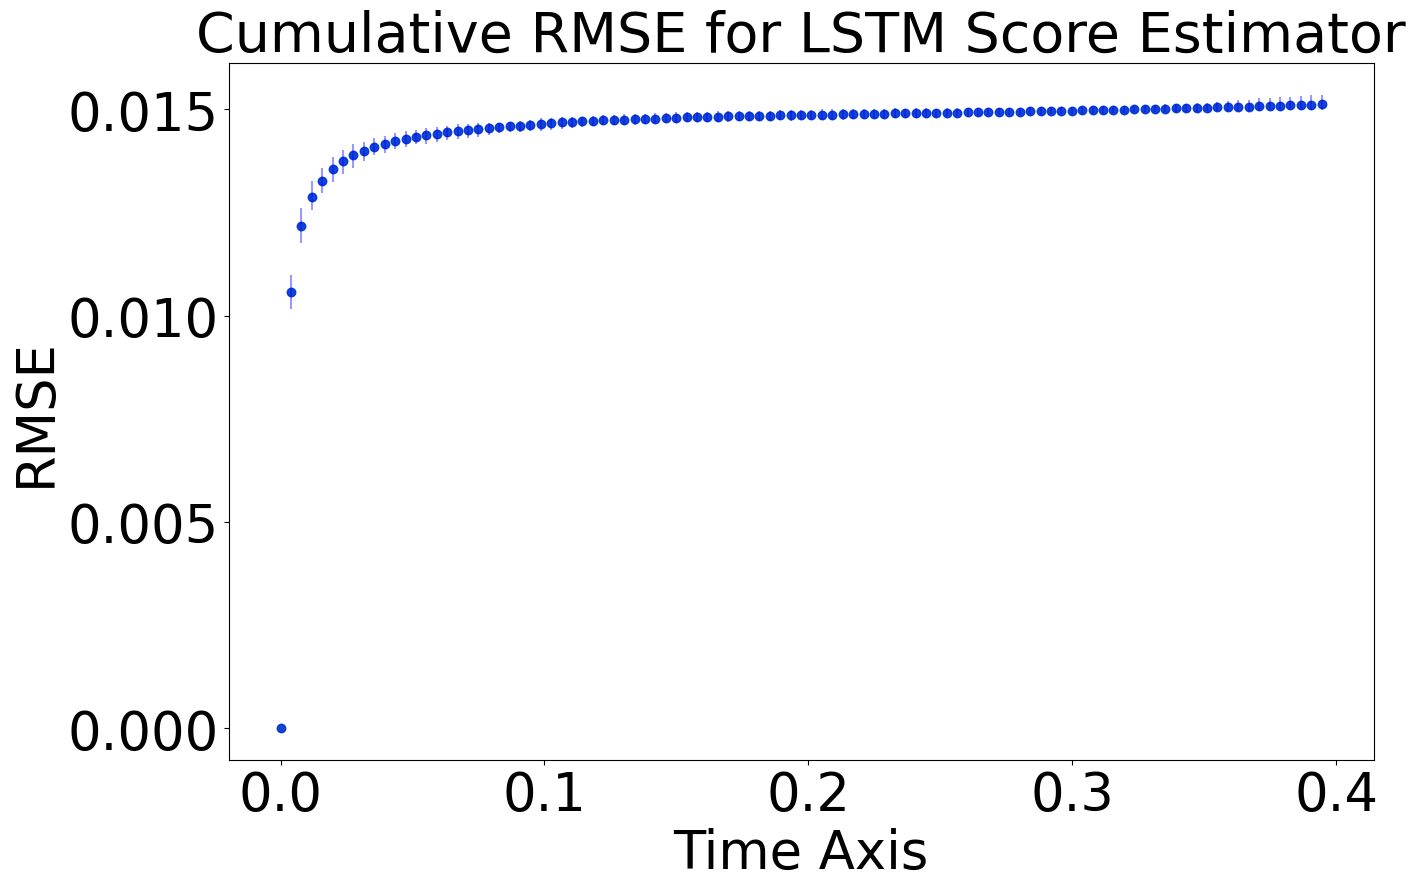

Final time cumulative RMSE local-time error 0.015118554551794635 with final IQR (0.0149833891740418, 0.015354710732923407) at Nepoch 100

0.020480689971977398 0.0009389474137108944 0.015118554551794635
0.0036974572006871218 0.0006909031880914644 0.015118554551794635


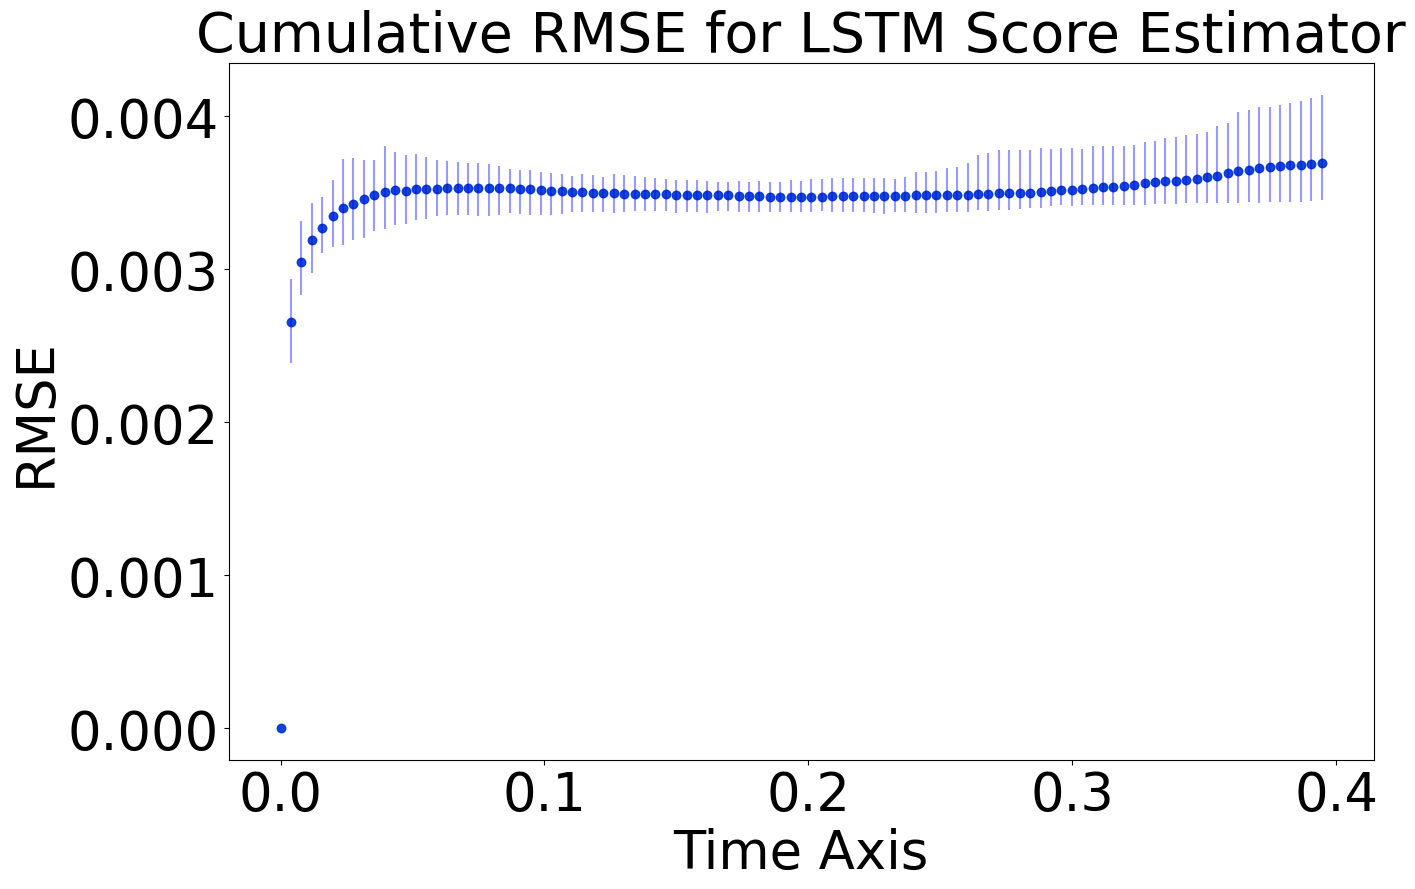

Final time cumulative RMSE local-time error 0.0036974572006871218 with final IQR (0.0034502938004480252, 0.00414119698853949) at Nepoch 300

0.006623709162109944 0.0006743078089825631 0.0036974572006871218
0.007649157446040564 0.001855073832586475 0.0036974572006871218
0.005850691834872355 0.00155273000193616 0.0036974572006871218
0.006535721288976212 0.0006557675775614533 0.0036974572006871218
0.006331152498522249 0.00312487412790987 0.0036974572006871218
0.007094622535507583 0.001720361029522219 0.0036974572006871218
0.009623355541802004 0.0018453363890287323 0.0036974572006871218
0.009624703009930872 0.002577166050592078 0.0036974572006871218


In [7]:
curr_rmse = np.inf
toSave = True
for Nepoch in config.max_epochs:
    try:
        if "_ST_" in config.scoreNet_trained_path:
            save_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_ST_fBiPot_DriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")
        else:
            save_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fBiPot_DriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")

        all_true_states = np.load(save_path + "_true_states.npy")/np.sqrt(config.deltaT)
        all_local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse)
        if total_local_errors[-1]  < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1] #- total_local_errors_minq[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fBiPot_DriftTrack_{Nepoch}Nep_PM_LSTM").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {curr_rmse} with final IQR {total_local_errors_minq[-1],total_local_errors_maxq[-1]} at Nepoch {Nepoch}\n")
    except FileNotFoundError:
        continue